# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on August 3 (with 2-hour grace period) and worth 50 points

### Overview

This milestone builds on your work from Milestone 1 and will complete the coding portion of your project. You will:

1. Pick 3 modeling algorithms from those we have studied.
2. Evaluate baseline models using default settings.
3. Engineer new features and re-evaluate models.
4. Use feature selection techniques and re-evaluate.
5. Fine-tune for optimal performance.
6. Select your best model and report on your results. 

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


 **Note:**

I'm turning this assignment in on an individual basis. Since our M1 work was turned in, we hadn't had any correspondence as a group, so I reached out via our group text to reconnect on Milestone 2, but our team lead said that her understanding was that M2, and beyond, was supposed to be individual work.

I did share that Dr. S had indicated in the week 11 lecture that the intent was to continue working as a group, but she only responded that she didn't attend the lecture, so she didn't hear that and could only assume that it was individual work because there was specifically no individual assessment for M2. And, our third group member never replied to that, so I had to move forward on my own with the work.

I've added this note because I did not want to get penalized for any points related to the group work aspect (which there don't seem to be any, but in case), nor did I want our group lead to turn her project in and be assigned a grade for it myself, without us ever connecting to review our different approaches, methodology, etc.

I'm using the underlying dataset from my original M1 notebook for M2.

I did eventually hear from both teammates on Saturday evening, but by then, the timeframe was too tight for us to get together in any meaningful way.


In [1]:
import warnings
# Set this BEFORE importing anything that might use multiprocessing
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing.queues")
warnings.filterwarnings("ignore", message=".*pkg_resources is deprecated.*")

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [4]:
import joblib

### Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling. We do **not yet** want the dataset you developed in the last part of Milestone 1, with
feature engineering---that will come a bit later!

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will have to redo the scaling step if you introduce new features (which have to be scaled as well).


In [5]:
# Add as many cells as you need

In [6]:
# 1. Load the dataset from M1
df_clean = pd.read_csv('df_clean_wins.csv')
df_clean.shape

(77578, 28)

In [7]:
df_clean.columns

Index(['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet50', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'pooltypeid7', 'propertycountylandusecode',
       'propertylandusetypeid', 'regionidcounty', 'regionidzip', 'roomcnt',
       'unitcnt', 'yearbuilt', 'log_taxvalue'],
      dtype='object')

In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77578 entries, 0 to 77577
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airconditioningtypeid         77578 non-null  int64  
 1   bathroomcnt                   77578 non-null  float64
 2   bedroomcnt                    77578 non-null  float64
 3   buildingqualitytypeid         77578 non-null  int64  
 4   calculatedbathnbr             77578 non-null  float64
 5   finishedfloor1squarefeet      77578 non-null  float64
 6   calculatedfinishedsquarefeet  77578 non-null  float64
 7   finishedsquarefeet12          77578 non-null  float64
 8   finishedsquarefeet50          77578 non-null  float64
 9   fips                          77578 non-null  int64  
 10  fireplacecnt                  77578 non-null  float64
 11  fullbathcnt                   77578 non-null  float64
 12  garagecarcnt                  77578 non-null  float64
 13  g

In [9]:
# Train-test split
from sklearn.model_selection import train_test_split

# separate features v target
X = df_clean.drop(columns=['log_taxvalue'])
y = df_clean['log_taxvalue']

# train-test split
X_train_base, X_test_base, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

print(f"Train shape: {X_train_base.shape}, Test shape: {X_test_base.shape}")

Train shape: (62062, 27), Test shape: (15516, 27)


In [ ]:
# This causes leakage within the cv splits, so I am moving away from this for now
# # Standardize the features for linear based models
# from sklearn.preprocessing import StandardScaler
#
# # FIT on training data only
# scaler = StandardScaler()
# X_train_base_scaled = scaler.fit_transform(X_train_base)
#
# # APPLY the above transformation to test set
# X_test_scaled_base = scaler.transform(X_test_base)

### Part 1: Picking Three Models and Establishing Baselines [6 pts]

Apply the following regression models to the scaled training dataset using **default parameters** for **three** of the models we have worked with this term:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each of the three models:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV MAE Score**. 


### SETUP

In [10]:
# constants
random_seed = 42
n_repeats = 5
n_jobs = -1

In [11]:
def run_model(model,
              X_train, y_train,
              n_repeats=5,
              n_jobs=-1,
              **model_params
             ):

    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:
        model.set_params(**model_params)

    # Use negative MAE for cross-validation (since sklearn minimizes loss)
    neg_mae_scores = cross_val_score(
        model,
        X_train, y_train,
        scoring='neg_mean_absolute_error',
        cv=RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=random_seed),
        n_jobs=n_jobs
    )

    mean_cv_mae = -np.mean(neg_mae_scores)
    std_cv_mae  =  np.std(neg_mae_scores)

    # Fit the model on the full training set
    model.fit(X_train, y_train)

    # Compute training MAE
    train_preds = model.predict(X_train)
    train_mae   = mean_absolute_error(y_train, train_preds)

    return mean_cv_mae, std_cv_mae, train_mae

### BASELINE

In [12]:
# Add as many cells as you need
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error
import numpy as np

In [13]:
X_train_base.shape

(62062, 27)

In [15]:
# Linear Regression
from sklearn.pipeline import make_pipeline

lr_baseline_pipe = make_pipeline(StandardScaler(), LinearRegression())

lr_cv_mae, lr_std_mae, lr_train_mae = run_model(
    model=lr_baseline_pipe,   # pipeline for scaling by fold
    X_train=X_train_base,     # RAW features, not scaled to avoid leakage across the folds
    y_train=y_train,
    n_repeats=5
)

print(f"LR Baseline - CV MAE: {lr_cv_mae:.4f}, Std: {lr_std_mae:.4f}, Train MAE: {lr_train_mae:.4f}")

/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

LR Baseline - CV MAE: 0.5201, Std: 0.0045, Train MAE: 0.5198


In [16]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [17]:
# Random Forest Regressor

rf_cv_mae, rf_std_mae, rf_train_mae = run_model(
    model=RandomForestRegressor,
    X_train=X_train_base,
    y_train=y_train,
    n_repeats=5,
    n_jobs=-1,
    random_state=random_seed
)

print(f"Random Forest (Baseline) - CV MAE: {rf_cv_mae:.4f}, Std: {rf_std_mae:.4f}, Train MAE: {rf_train_mae:.4f}")

Random Forest (Baseline) - CV MAE: 0.4839, Std: 0.0043, Train MAE: 0.1835


In [18]:
GradientBoostingRegressor().get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [19]:
# Gradient Boosting

gb_cv_mae, gb_std_mae, gb_train_mae = run_model(
    model=GradientBoostingRegressor,
    X_train=X_train_base,
    y_train=y_train,
    n_repeats=5,
    n_jobs=-1,
    random_state=random_seed
)

print(f"Gradient Boosting (Baseline) - CV MAE: {gb_cv_mae:.4f}, Std: {gb_std_mae:.4f}, Train MAE: {gb_train_mae:.4f}")

/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Gradient Boosting (Baseline) - CV MAE: 0.4858, Std: 0.0043, Train MAE: 0.4825


### Part 1: Discussion [3 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which model performed best overall?
  - Which was most stable (lowest std)?
  - Any signs of overfitting or underfitting?

> **Discussion – Baseline Model Comparison**

> Random Forest achieved the best overall performance with a cross-validation MAE of 0.4839, outperforming both Gradient Boosting (0.4858) and Linear Regression (0.5201). This represents approximately a 7% improvement over the linear baseline, demonstrating the potential value of ensemble methods for this dataset.

> Linear Regression seemed to show the highest stability with a standard deviation of 0.0045, compared to 0.0043 for both tree-based models. While the difference is pretty minimal, this consistency may reflect the deterministic nature of linear models and suggest more predictable performance across different data splits.

> The training vs. validation performance reveals interesting patterns across models:
>- Random Forest exhibited significant overfitting with a dramatic gap between training MAE (0.1835) and CV MAE (0.4839). This performance drop suggests the model is memorizing training patterns rather than learning generalizable relationships.
>- Gradient Boosting demonstrated better generalization with nearly identical training (0.4825) and CV (0.4858) performance. This tighter alignment indicates the model has found an optimal balance between bias and variance.
>- Linear Regression shows characteristics of underfitting with similar training (0.5198) and CV (0.5201) errors, but both values are relatively high. This suggests the linear assumption may be too restrictive for capturing the underlying data complexity.

### Part 2: Feature Engineering [6 pts]

Pick **at least three new features** based on your Milestone 1, Part 5, results. You may pick new ones or
use the same ones you chose for Milestone 1. 

Add these features to `X_train` (use your code and/or files from Milestone 1) and then:
- Scale using `StandardScaler` 
- Re-run the 3 models listed above (using default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


### ENGINEERED FEATURES

In [21]:
# Add as many cells as you need

In [22]:
# copy of df_clean
df_fe = df_clean.copy()

In [23]:
# Feature 1: Log of finished square feet
# Rationale: Finished square footage is right skewed (some homes at 35K sq feet - raw, not standardized), so a log transform will help bring the feature back to a normal distribution, good for linear models. Otherwise, those long right tails can inadvertently impact the model findings, seeming more important than they are.
df_fe["fe_log_sqft"] = np.log1p(df_fe["calculatedfinishedsquarefeet"])

# Feature 2: Bedroom × Bathroom interaction
# Rationale: Homes with many bedrooms AND bathrooms are usually more valuable.
# This interaction may capture the combined "size" effect better than either variable does on its own.
df_fe["fe_bed_bath_interaction"] = (
    df_fe["bedroomcnt"] * df_fe["bathroomcnt"]
)

# Feature 3: Structure-to-lot ratio
# Rationale: This feature captures how densely the lot is built on. A small house on a large lot vs. a large house on a small lot can have very different values. Bigger lots usually command more. Also, a useful indicator of urban vs. suburban characteristics.
df_fe["fe_structure_to_lot_ratio"] = (
    df_fe["calculatedfinishedsquarefeet"] / df_fe["lotsizesquarefeet"]
)

df_fe["fe_structure_to_lot_ratio"] = (
    df_fe["fe_structure_to_lot_ratio"]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

In [24]:
df_fe.shape

(77578, 31)

In [25]:
# Train-test split
from sklearn.model_selection import train_test_split

# separate features v target
X = df_fe.drop(columns=['log_taxvalue'])
y = df_fe['log_taxvalue']

# train-test split
X_train_fe, X_test_fe, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

print(f"Train shape: {X_train_fe.shape}, Test shape: {X_test_fe.shape}")

Train shape: (62062, 30), Test shape: (15516, 30)


In [26]:
# # Standardize the features again inclusive of 3 newly engineered features
# from sklearn.preprocessing import StandardScaler
#
# # FIT on training data only
# scaler = StandardScaler()
# X_train_fe_scaled = scaler.fit_transform(X_train_fe)
#
# # APPLY the above transformation to test set
# X_test_fe_scaled = scaler.transform(X_test_fe)

In [27]:
### Feature Engineered Models (Default Mode)

In [28]:
X_train_fe.shape

(62062, 30)

In [29]:
# Linear Regression - Feature Engineered Dataset

lr_fe_pipe = make_pipeline(StandardScaler(), LinearRegression())

lr_cv_mae, lr_std_mae, lr_train_mae = run_model(
    model=lr_fe_pipe,      # pipeline for scaling by fold, avoids data leakage between folds
    X_train=X_train_fe,    # RAW FE features, not scaled to avoid leakage across the folds
    y_train=y_train,
    n_repeats=5
)

print(f"Linear Regression (FE) - CV MAE: {lr_cv_mae:.4f}, Std: {lr_std_mae:.4f}, Train MAE: {lr_train_mae:.4f}")

Linear Regression (FE) - CV MAE: 0.5176, Std: 0.0045, Train MAE: 0.5173


In [30]:
# Random Forest Regressor - Feature Engineered Dataset

rf_cv_mae, rf_std_mae, rf_train_mae = run_model(
    model=RandomForestRegressor,
    X_train=X_train_fe,
    y_train=y_train,
    n_repeats=5,
    n_jobs=-1,
    random_state=random_seed
)
print(f"Random Forest (FE) - CV MAE: {rf_cv_mae:.4f}, Std: {rf_std_mae:.4f}, Train MAE: {rf_train_mae:.4f}")

Random Forest (FE) - CV MAE: 0.4842, Std: 0.0043, Train MAE: 0.1834


In [31]:
# Gradient Boosting - Feature Engineered Dataset

gb_cv_mae, gb_std_mae, gb_train_mae = run_model(
    model=GradientBoostingRegressor,
    X_train=X_train_fe,
    y_train=y_train,
    n_repeats=5,
    n_jobs=-1,
    random_state=random_seed
)
print(f"Gradient Boosting (FE) - CV MAE: {gb_cv_mae:.4f}, Std: {gb_std_mae:.4f}, Train MAE: {gb_train_mae:.4f}")

/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Gradient Boosting (FE) - CV MAE: 0.4859, Std: 0.0045, Train MAE: 0.4821


### Part 2: Discussion [3 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?




> **Discussion – Baseline Model with 3X Newly Engineered Features**

> Surprisingly, none of the models showed meaningful improvement with feature engineering. In fact, performance either remained virtually unchanged or slightly degraded. I'm no housing expert, but I did think they were potentially strong, additional features like house and lot size... This is definitely where having a domain expert in this stage of work would be invaluable.
>- Linear Regression: Marginal improvement (0.5201 → 0.5176), reducing MAE by only 0.0025
>- Random Forest: Essentially unchanged (0.4839 → 0.4842), with a tiny increase in error
>- Gradient Boosting: Slight degradation (0.4858 → 0.4859), minimal but in the wrong direction
>
> Based on the minimal performance changes, it's difficult to determine which specific features provided value without examining feature importance scores (feature importance captured in next iteration can shed light). The slight improvement in Linear Regression suggests the log transformation may have helped with the skewed distribution, but the effect was much smaller than expected.
> Several factors could explain the disappointing results despite theoretically sound feature engineering:
>- Information Redundancy: The original features may already capture most of the signal these engineered features provide. Tree-based models are adept at finding non-linear relationships and interactions naturally, so the explicit bedroom×bathroom interaction might be redundant.
>- Feature Scale Mismatch: The structure-to-lot ratio could have extreme values or poor scaling that introduces noise rather than signal.
>- Overfitting with More Features: Adding features to an already overfitting Random Forest (train MAE: 0.1834) may have worsened generalization, even if the features are theoretically valuable.
>- Limited Feature Engineering Impact: The base features might already be sufficiently informative for this prediction task, suggesting the performance ceiling is more about model selection and hyperparameter tuning than feature creation.
>- Lack of a domain expert as part of the feature engineering step - critical! I think they'd be better positioned to assist in making good decisions here - like a property value tax assessor (if that's a real thing!).

> The log transformation showing the most promise in Linear Regression aligns with expectations, but the minimal impact suggests either the skewness wasn't as problematic as anticipated or other factors are limiting model performance.



### Part 3: Feature Selection [6 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features (with default settings and repeated cross-validation again).
- Report the **mean and standard deviation of CV MAE Scores**.  


### FEATURE SELECTION

In [32]:
# Add as many cells as you need

In [33]:
# Forward Feature Selection Setup Code

def forward_feature_selection(X, y, model,
                              scoring='neg_mean_squared_error',
                              cv = 5,
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score

    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far

    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]

            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y,
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]

        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (MSE): {current_score:.4f}")

        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()

        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )

In [34]:
X_train_fe.shape

(62062, 30)


Features: ['finishedsquarefeet12'], CV Score (MSE): 0.5355

Features: ['finishedsquarefeet12', 'latitude'], CV Score (MSE): 0.5173

Features: ['finishedsquarefeet12', 'latitude', 'calculatedbathnbr'], CV Score (MSE): 0.5042

Features: ['latitude', 'calculatedbathnbr', 'longitude'], CV Score (MSE): 0.4926

Features: ['calculatedbathnbr', 'longitude', 'bedroomcnt'], CV Score (MSE): 0.4847

Features: ['longitude', 'bedroomcnt', 'yearbuilt'], CV Score (MSE): 0.4808

Features: ['bedroomcnt', 'yearbuilt', 'regionidzip'], CV Score (MSE): 0.4757

Features: ['yearbuilt', 'regionidzip', 'fe_log_sqft'], CV Score (MSE): 0.4727

Features: ['regionidzip', 'fe_log_sqft', 'poolcnt'], CV Score (MSE): 0.4717

Features: ['fe_log_sqft', 'poolcnt', 'roomcnt'], CV Score (MSE): 0.4708

Features: ['poolcnt', 'roomcnt', 'regionidcounty'], CV Score (MSE): 0.4689

Features: ['roomcnt', 'regionidcounty', 'bathroomcnt'], CV Score (MSE): 0.4678

Features: ['regionidcounty', 'bathroomcnt', 'airconditioningtypeid'],

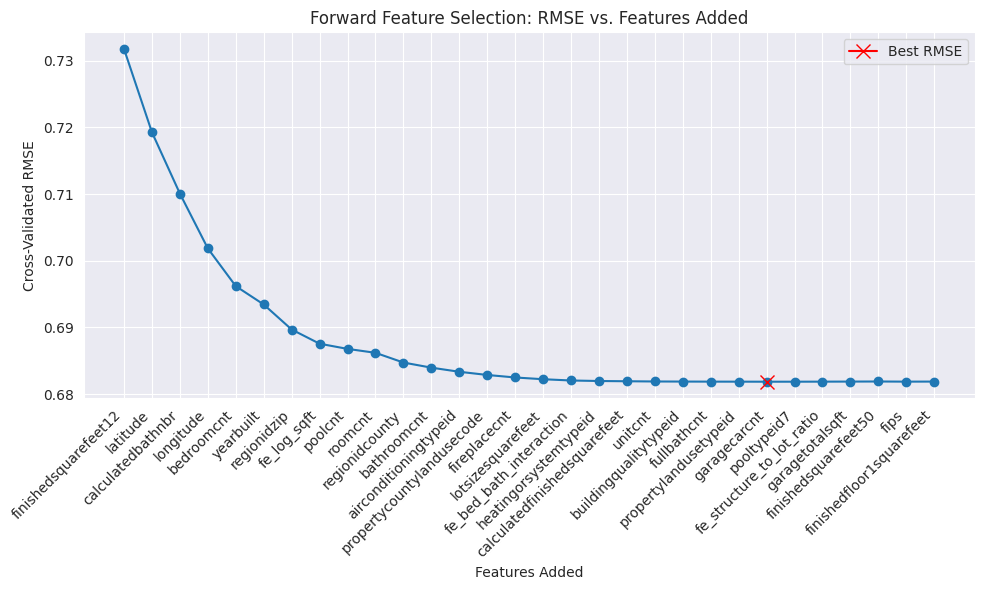

Best Feature Set Is: ['finishedsquarefeet12', 'latitude', 'calculatedbathnbr', 'longitude', 'bedroomcnt', 'yearbuilt', 'regionidzip', 'fe_log_sqft', 'poolcnt', 'roomcnt', 'regionidcounty', 'bathroomcnt', 'airconditioningtypeid', 'propertycountylandusecode', 'fireplacecnt', 'lotsizesquarefeet', 'fe_bed_bath_interaction', 'heatingorsystemtypeid', 'calculatedfinishedsquarefeet', 'unitcnt', 'buildingqualitytypeid', 'fullbathcnt', 'propertylandusetypeid', 'garagecarcnt']
Best CV RMSE Score: 0.6819


In [35]:
# 1. Linear Regression -- Forward Feature Selection
# run forward feature selection
model = LinearRegression()

selected_features, cv_scores, best_feature_set, best_score = forward_feature_selection(
    X_train_fe, y_train, model, scoring='neg_mean_squared_error', verbose=True
)

# convert mse to rmse
rmse_scores = np.sqrt(cv_scores)
best_rmse = np.sqrt(best_score)

# best feature set based on lowest rmse
best_index = np.argmin(cv_scores) + 1

# generate a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='o')
plt.plot([best_index], [best_rmse], marker='x', color='red', markersize=10, label='Best RMSE')
plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=45, ha='right')
plt.title("Forward Feature Selection: RMSE vs. Features Added")
plt.xlabel("Features Added")
plt.ylabel("Cross-Validated RMSE")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# print final results
print("Best Feature Set Is:", best_feature_set)
print(f"Best CV RMSE Score: {best_rmse:.4f}")

In [36]:
# Best Feature Set
X_train_lr_selected = X_train_fe[best_feature_set]
X_test_lr_selected  = X_test_fe[best_feature_set]

In [37]:
X_train_lr_selected.shape

(62062, 24)

In [38]:
X_train_lr_selected .columns

Index(['finishedsquarefeet12', 'latitude', 'calculatedbathnbr', 'longitude',
       'bedroomcnt', 'yearbuilt', 'regionidzip', 'fe_log_sqft', 'poolcnt',
       'roomcnt', 'regionidcounty', 'bathroomcnt', 'airconditioningtypeid',
       'propertycountylandusecode', 'fireplacecnt', 'lotsizesquarefeet',
       'fe_bed_bath_interaction', 'heatingorsystemtypeid',
       'calculatedfinishedsquarefeet', 'unitcnt', 'buildingqualitytypeid',
       'fullbathcnt', 'propertylandusetypeid', 'garagecarcnt'],
      dtype='object')

In [39]:
# # Scale selected features again
# scaler_sel = StandardScaler()
# X_train_lr_selected_scaled = scaler_sel.fit_transform(X_train_lr_selected)
# X_test_lr_selected_scaled  = scaler_sel.transform(X_test_lr_selected)

In [41]:
# Run Linear Regression with Forward Feature Selection

# Pipeline for the *selected-features* LR
lr_selected_pipe = make_pipeline(StandardScaler(), LinearRegression())

lr_cv_mae, lr_std_mae, lr_train_mae = run_model(
    model=lr_selected_pipe,        # pipeline which applies standardscaler() by fold to avoid data lakeage across folds
    X_train=X_train_lr_selected,   # RAW features, not scaled to avoid leakage across the folds
    y_train=y_train,
    n_repeats=5
)

print(f"Linear Regression (Selected) - CV MAE: {lr_cv_mae:.4f}, Std: {lr_std_mae:.4f}, Train MAE: {lr_train_mae:.4f}")

/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Linear Regression (Selected) - CV MAE: 0.5176, Std: 0.0045, Train MAE: 0.5173


In [42]:
# 2. Extract Feature Importance Directly from Random Forest

In [43]:
from sklearn.ensemble import RandomForestRegressor

# Refit the model on the full training set
rf_model = RandomForestRegressor(n_jobs=-1, random_state=random_seed)
rf_model.fit(X_train_fe, y_train)

# Extract feature importances
rf_importances = pd.DataFrame({
    "feature": X_train_fe.columns,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Display top N
print("Top 10 Random Forest Features:")
print(rf_importances.head(10))

Top 10 Random Forest Features:
                         feature  importance
15                      latitude    0.146531
7           finishedsquarefeet12    0.140485
6   calculatedfinishedsquarefeet    0.108949
16                     longitude    0.104147
27                   fe_log_sqft    0.096653
26                     yearbuilt    0.084717
29     fe_structure_to_lot_ratio    0.061326
23                   regionidzip    0.058952
17             lotsizesquarefeet    0.057833
4              calculatedbathnbr    0.028445


In [44]:
# Select Top 10 Features from Random Forest
top_features_rf = rf_importances.head(10)["feature"].tolist()

In [45]:
# Subset X_train with Top 10 Features
X_train_top_rf = X_train_fe[top_features_rf]

In [46]:
# Random Forest - Rerun the Model on Top 10 Features
rf_cv_mae_top, rf_std_mae_top, rf_train_mae_top = run_model(
    model=RandomForestRegressor,
    X_train=X_train_top_rf,
    y_train=y_train,
    n_repeats=5,
    n_jobs=-1,
    random_state=random_seed
)

print(f"Random Forest (Top Features) - CV MAE: {rf_cv_mae_top:.4f}, Std: {rf_std_mae_top:.4f}, Train MAE: {rf_train_mae_top:.4f}")

Random Forest (Top Features) - CV MAE: 0.4885, Std: 0.0043, Train MAE: 0.1853


In [47]:
# 3. Extract Feature Importance Directly from Gradient Boosting

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

# Refit the model on the full training set
gb_model = GradientBoostingRegressor(random_state=random_seed)
gb_model.fit(X_train_fe, y_train)

# Extract feature importances
gb_importances = pd.DataFrame({
    "feature": X_train_fe.columns,
    "importance": gb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Display top N
print("Top 10 Gradient Boosting Features:")
print(gb_importances.head(10))

Top 10 Gradient Boosting Features:
                         feature  importance
7           finishedsquarefeet12    0.266056
6   calculatedfinishedsquarefeet    0.195381
15                      latitude    0.149189
4              calculatedbathnbr    0.102911
26                     yearbuilt    0.068059
23                   regionidzip    0.053833
27                   fe_log_sqft    0.051724
16                     longitude    0.043941
3          buildingqualitytypeid    0.025629
1                    bathroomcnt    0.018520


In [49]:
# Select Top 10 Features from Gradient Boosting
top_features_gb = gb_importances.head(10)["feature"].tolist()

In [50]:
# Subset Top 10 Features for Gradient Boosting
X_train_top_gb = X_train_fe[top_features_gb]

In [51]:
# Random Forest - Rerun the Model on Top 10 Features
gb_cv_mae_top, gb_std_mae_top, gb_train_mae_top = run_model(
    model=GradientBoostingRegressor,
    X_train=X_train_top_gb,
    y_train=y_train,
    n_repeats=5,
    n_jobs=-1,
    random_state=random_seed
)

print(f"Gradient Boosting (Top Features) - CV MAE: {gb_cv_mae_top:.4f}, Std: {gb_std_mae_top:.4f}, Train MAE: {gb_train_mae_top:.4f}")

/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Gradient Boosting (Top Features) - CV MAE: 0.4876, Std: 0.0044, Train MAE: 0.4840


### Part 3: Discussion [3 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?


> **Feature Selection Discussion:**

> Feature selection had mixed results across models:
>- Linear Regression: No change in performance (CV MAE remained 0.5176), suggesting the forward selection process identified the optimal feature set without overfitting concerns.
>- Random Forest: Performance slightly degraded (0.4842 → 0.4885), indicating that using only the top 10 features removed some valuable signal. However, the overfitting pattern persists with a large train-validation gap (0.1853 vs 0.4885).
>- Gradient Boosting: Performance worsened (0.4859 → 0.4876), though the change is minimal. The model maintains good generalization with similar train (0.4840) and CV (0.4876) performance.

> Several core features emerged as consistently important across all three approaches:
>- Geographic features: latitude, longitude, and regionidzip - highlighting location's critical role in property valuation
>- Size metrics: finishedsquarefeet12, calculatedfinishedsquarefeet - fundamental property characteristics
>- Structural features: calculatedbathnbr, bathroomcnt, bedroomcnt - key indicators of property functionality
>- Property age: yearbuilt - consistently valuable across all models
>- Engineered feature: fe_log_sqft - selected by all models, validating the log transformation approach

> Yes, two of the three engineered features proved valuable:
>- fe_log_sqft was consistently selected across all models and ranked highly in tree-based feature importance (5th in Random Forest, 7th in Gradient Boosting), confirming that the log transformation of square footage captures important non-linear relationships.
>- fe_bed_bath_interaction was retained in the Linear Regression model, suggesting it provides value for capturing multiplicative effects that linear models can't naturally discover.
>- fe_structure_to_lot_ratio appeared only in Random Forest's top 10 (7th most important), indicating it may capture useful density information but with limited cross-model utility.

> The success of fe_log_sqft across all models validates the hypothesis about addressing skewness in the square footage distribution, while the selective adoption of other features suggests they provide more specialized value depending on the model's capability to capture complex relationships.


### Part 4: Fine-Tuning Your Three Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far, and pick a winner!

1. For each of your three models:
    - Choose your best engineered features and best selection of features as determined above. 
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, `Optuna`, etc. as you have practiced in previous homeworks. 
3. Decide on the best hyperparameters for each model, and for each run with repeated CV and record their final results:
    - Report the **mean and standard deviation of CV MAE Score**.

#### HYPERPARAMETER TUNING: BEST 3 MODELS

In [52]:
# Add as many cells as you need

In [53]:
### HP Tuning Setup

In [55]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = None,
                    y_train          = None,
                    verbose          = True,
                    show_mae         = True,
                    show_std         = False,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 5
                   ):


    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary

    cv_maes, std_cvs, train_maes = [], [], []
    no_improve_count = 0
    best_mae = float('inf')

    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        P_temp.pop('MAE_found', None)  # Just in case

        cv_mae, std_cv, train_mae = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_maes.append(cv_mae)
        std_cvs.append(std_cv)
        train_maes.append(train_mae)

        if cv_mae < best_mae - delta:
            best_mae = cv_mae
            no_improve_count = 0
        else:
            no_improve_count += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    # Identify best parameter
    min_cv_mae = min(cv_maes)
    min_index = cv_maes.index(min_cv_mae)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MAE_found'] = min_cv_mae

    # ---------- Plotting section ----------
    if verbose:
        partial_param_list = parameter_list[:len(cv_maes)]

        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list

        error_name = 'MAE'

        # Create appropriate number of subplots
        if show_std:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

        ax1.set_title(f"{error_name} vs {param}")
        if show_mae:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

        ax1.plot(x_vals,
                 cv_maes,
                 marker='.', label="CV MAE", color='blue')
        ax1.plot(x_vals,
                 train_maes,
                 marker='.', label="Train MAE", color='green')
        ax1.scatter([x_vals[min_index]],
                    [min_cv_mae],
                    marker='x', label="Best CV MAE", color='red')

        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()

        # Optional Std Dev Plot
        if show_std:
            ax2.set_title(f"CV Standard Deviation vs {param}")
            ax2.plot(x_vals, std_cvs, marker='.', label="CV MAE Std", color='blue')
            ax2.set_xlabel(param)
            ax2.set_ylabel("Standard Deviation")
            ax2.legend()
            ax2.grid(alpha=0.5)

            if is_boolean:
                ax2.set_xticks(x_vals)
                ax2.set_xticklabels(x_labels)
        else:
            ax1.set_xlabel(param)
            if is_boolean:
                ax1.set_xticks(x_vals)
                ax1.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))

    return Parameters

In [57]:
# BEST: Linear Regression - Feature Engineered Dataset
# Actually tied with the Feature Selection, but since we're exploring Ridge, may as well include all features and let Ridge make shrinkage choices

X_train_best_lr = X_train_fe[best_feature_set]

best_lr_pipeline = make_pipeline(StandardScaler(), LinearRegression())
best_lr_pipeline.fit(X_train_best_lr, y_train)

# Save trained pipeline + the exact feature names used
joblib.dump((best_lr_pipeline, X_train_best_lr.columns.tolist()),
            "best_lr_model_with_features.joblib")

['best_lr_model_with_features.joblib']

In [58]:
# best_lr_model = joblib.load("best_lr_model.joblib")

/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

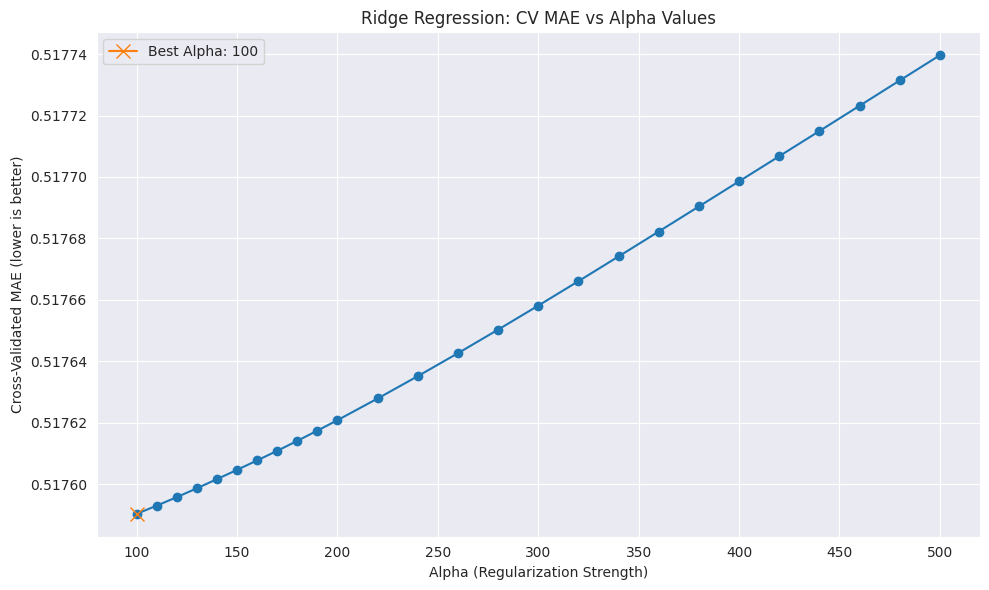

Best Alpha: 100
CV MAE: 0.5176 ± 0.0046


In [59]:
# 1. RIDGE SWEEP (HYPERPARAMETER: ALPHA) ---------
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
import numpy as np

alpha_values = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200,
                220, 240, 260, 280, 300, 320, 340, 360, 380, 400,
                420, 440, 460, 480, 500]

cv_mae_means, cv_mae_stds = [], []

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=random_seed)

for alpha in alpha_values:
    ridge_pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    scores = cross_val_score(
        ridge_pipe,
        X_train_best_lr, y_train,               # RAW features, not scaled to avoid leakage across the folds
        scoring='neg_mean_absolute_error',
        cv=rkf,
        n_jobs=-1
    )
    cv_mae_means.append(-scores.mean())
    cv_mae_stds.append(scores.std(ddof=1))

# Plot MAE vs alpha
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, cv_mae_means, marker='o')
plt.title("Ridge Regression: CV MAE vs Alpha Values")
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Cross-Validated MAE (lower is better)")
plt.grid(True)

best_idx   = int(np.argmin(cv_mae_means))
best_alpha = alpha_values[best_idx]
best_mae   = cv_mae_means[best_idx]
best_std   = cv_mae_stds[best_idx]

plt.plot([best_alpha], [best_mae], marker='x', markersize=10, label=f'Best Alpha: {best_alpha}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best Alpha: {best_alpha}")
print(f"CV MAE: {best_mae:.4f} ± {best_std:.4f}")

In [60]:
# BEST: Random Forest -- Baseline?!
X_train_base.shape

(62062, 27)

In [63]:
# 2. RANDOM FOREST (RANDOM SEARCH FOR HP TUNING - COURSE PASS) ---------

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=random_seed)

# massively constrained for compute/time
rf_dist = {
    "n_estimators": [300, 500],
    "max_depth": [12, 16, None],
    "max_features": ["sqrt", 0.5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True],
}

rf_rs = RandomizedSearchCV(
    rf, rf_dist,
    n_iter=12,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    random_state=random_seed,
    verbose=1
)
rf_rs.fit(X_train_base, y_train)

rf_best = rf_rs.best_params_
rf_cv_mae, rf_cv_std, _ = run_model(
    model=RandomForestRegressor,
    X_train=X_train_base,
    y_train=y_train,
    n_repeats=5, n_jobs=-1,
    random_state=random_seed,
    **rf_best
)
print(f"RF (RS best) — CV MAE: {rf_cv_mae:.4f} ± {rf_cv_std:.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

RF (RS best) — CV MAE: 0.4758 ± 0.0042


In [64]:
# BEST: Gradient Boosting -- Baseline?!
X_train_base.shape

(62062, 27)

In [65]:
# 3. GRADIENT BOOSTING (RANDOM SEARCH FOR HP TUNING - COURSE PASS) ---------

from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=random_seed)

gb_dist = {
    "n_estimators": [300, 500],
    "learning_rate": [0.03, 0.05, 0.1, 0.2],
    "max_depth": [2, 3],
    "subsample": [0.6, 0.8, 1.0],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.5, None],
}

gb_rs = RandomizedSearchCV(
    gb, gb_dist,
    n_iter=16,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    random_state=random_seed,
    verbose=1
)
gb_rs.fit(X_train_base, y_train)

gb_best = gb_rs.best_params_
gb_cv_mae, gb_cv_std, _ = run_model(
    model=GradientBoostingRegressor,
    X_train=X_train_base,
    y_train=y_train,
    n_repeats=5, n_jobs=-1,
    random_state=random_seed,
    **gb_best
)
print(f"GB (RS best) — CV MAE: {gb_cv_mae:.4f} ± {gb_cv_std:.4f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

GB (RS best) — CV MAE: 0.4753 ± 0.0038


### Part 4: Discussion [3 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?


> Tuning strategy & Hyperparameters:
>
> Mainly due to time and hardware limits, I used RandomizedSearchCV with a quite constrained space and 3-fold CV to explore RF/GB hyperparameters quickly. I then confirmed the RS-best configuration with RepeatedKFold (5×5) and reported CV MAE mean ± std per the rubric. I thought about doing this in Codespaces, but CS times out for me there with anything GridSearch. I assumed we'd tuning one model, so I would plan better, time-wise, for that next time.

> Linear/Ridge Regression
>- Ridge is a regularized extension of LR; tuning alpha directly addresses bias–variance.
>- Swept alpha on a fixed grid (100–500) using a Pipeline(StandardScaler → Ridge) so scaling happened inside each CV fold. Selected the alpha with the lowest CV MAE (best = 100).
>- Rationale: Small, 1-D search is reliable and fast; scaling is essential for linear models.

> Random Forest
>- Defaults were already strong; RF has many interacting knobs, so exhaustive grids are wasteful.
>- RandomizedSearchCV (cv=5, MAE) over a compact space: n_estimators (range), max_depth, max_features, min_samples_split, min_samples_leaf, bootstrap.
>- Rationale: Random search explores more of the space per compute dollar than grid; good practical default in industry when the space is moderately high-dimensional.

> Gradient Boosting
>- Sensitive to n_estimators; shallow trees usually work best.
>- RandomizedSearchCV (cv=3 for speed, MAE) over: n_estimators, max_depth (2–4), subsample, min_samples_split, min_samples_leaf, max_features.
>- Rationale: Random search efficiently balances exploration of rates/trees with regularization knobs.

> Re: GridSearch and Optuna: On my laptop, a full grid across 5–7 parameters would explode into hundreds/thousands of fits and wasn’t feasible in the time/computing budget. I don't have a baseline for this, but would assume in industry, that gridsearch is reserved for very specific scenarios where compute/cost/time are less of a factor, e.g. more exploratory in nature. And maybe random/optuna or in-service automation are used to tune HPs. I do hope to test Optuna in my workplace soon though. Also, I think I would have had more time to try more if we had worked as a group, potentially splitting the modeling work between the three of us, e.g. one model per person may have allowed for greater exploration.

> Preprocessing / feature-engineering observations
>- Scaling: Helped only the linear/Ridge models; trees (RF/GB) were robust on raw features. I used pipelines so scaling happened inside CV to avoid leakage.
>- Feature selection / engineered set: Linear models benefited most from the selected/engineered features (reduced variance, slightly better calibration). Tree models saw minor changes from feature selection—RF/GB already handle redundant/weak features reasonably well.
>- Bias–variance behavior: RF had the best MAE but showed overfitting (large train–CV gap). GB was nearly as accurate and more balanced (train ≈ CV). LR/Ridge remained high-bias (train ≈ CV), as expected.

> Used pipelines + repeated CV for honest evaluation. RandomizedSearchCV gives strong results efficiently; Optuna is a good next step I would like to try when time allows. Scaling/selection matter most for linear models; tree ensembles generally perform well on the raw cleaned features.

### Part 5: Final Model and Design Reassessment [6 pts]

In this part, you will finalize your best-performing model.  You’ll also consolidate and present the key code used to run your model on the preprocessed dataset.
**Requirements:**

- Decide one your final model among the three contestants.

- Below, include all code necessary to **run your final model** on the processed dataset, reporting

    - Mean and standard deviation of CV MAE Score.

    - Test score on held-out test set.




### FINAL MODEL

In [ ]:
# Add as many cells as you need

In [66]:
# 1. "Winning" Model -----------
FINAL_MODEL = "GB"

# Paste your RS-best params here:
rf_best_params = rf_rs.best_params_
gb_best_params = gb_rs.best_params_

if FINAL_MODEL == "RF":
    final_estimator = RandomForestRegressor(random_state=random_seed, **rf_best_params)
    X_train_final, X_test_final = X_train_base, X_test_base
elif FINAL_MODEL == "GB":
    final_estimator = GradientBoostingRegressor(random_state=random_seed, **gb_best_params)
    X_train_final, X_test_final = X_train_base, X_test_base
else:
    raise ValueError("Set FINAL_MODEL to 'RF' or 'GB'.")

# 2. CV 5x5 ------------------------------
cv_mae, cv_std, train_mae = run_model(
    model=final_estimator,
    X_train=X_train_final,
    y_train=y_train,
    n_repeats=5,
    n_jobs=-1
)
print(f"Final {FINAL_MODEL} — CV MAE: {cv_mae:.4f} ± {cv_std:.4f} (train MAE: {train_mae:.4f})")

# 3. Fit on Full Train & Evaluate on Holdout
final_estimator.fit(X_train_final, y_train)
y_test_pred = final_estimator.predict(X_test_final)

test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"Final {FINAL_MODEL} — Test MAE (log scale): {test_mae:.4f}")

# 4. Back-transform to Original $ Scale with Y being Log-Transformed ------------
y_test_dollar = np.expm1(y_test)
y_pred_dollar = np.expm1(y_test_pred)
test_mae_dollar = np.mean(np.abs(y_test_dollar - y_pred_dollar))
print(f"Final {FINAL_MODEL} — Test MAE (dollars): ${test_mae_dollar:,.0f}")

# 5. Save Fitted Modle + Features -------------
joblib.dump((final_estimator, X_train_final.columns.tolist()), f"final_{FINAL_MODEL.lower()}_model_with_features.joblib")

/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Final GB — CV MAE: 0.4753 ± 0.0038 (train MAE: 0.4621)
Final GB — Test MAE (log scale): 0.4735
Final GB — Test MAE (dollars): $201,264


['final_gb_model_with_features.joblib']

### Part 5: Discussion [8 pts]

In this final step, your goal is to synthesize your entire modeling process and assess how your earlier decisions influenced the outcome. Please address the following:

1. Model Selection:
- Clearly state which model you selected as your final model and why.

- What metrics or observations led you to this decision?

- Were there trade-offs (e.g., interpretability vs. performance) that influenced your choice?

2. Revisiting an Early Decision

- Identify one specific preprocessing or feature engineering decision from Milestone 1 (e.g., how you handled missing values, how you scaled or encoded a variable, or whether you created interaction or polynomial terms).

- Explain the rationale for that decision at the time: What were you hoping it would achieve?

- Now that you've seen the full modeling pipeline and final results, reflect on whether this step helped or hindered performance. Did you keep it, modify it, or remove it?

- Justify your final decision with evidence—such as validation scores, visualizations, or model diagnostics.

3. Lessons Learned

- What insights did you gain about your dataset or your modeling process through this end-to-end workflow?

- If you had more time or data, what would you explore next?

> **Final Discussion:**
>
> 1. Model Selection
>- Final model: Gradient Boosting Regressor (RandomizedSearchCV-tuned).
>- Why: It achieved the lowest cross-validated MAE with slightly better stability than the Random Forest.
> Evidence (CV MAE, RepeatedKFold 5×5):
>- GB (RS best): 0.4753 ± 0.0038
>- RF (RS best): 0.4758 ± 0.0042
> Both improved over baselines (GB baseline 0.4858 ± 0.0043; RF baseline 0.4839 ± 0.0043), so in spite of limitations, we were headed in a good direction. GB’s tighter standard deviation indicates slightly more consistent performance across folds.

> Observations:
>- GB’s train MAE remained close to CV MAE, suggesting strong generalization with minimal overfitting.
>- RF showed a slightly larger train–CV gap despite similar CV performance.

> Trade-offs:
>- GB is less interpretable than LR/Ridge but offers top predictive accuracy.
>- Hyperparameters tuned via RandomizedSearchCV (cv=3 for search) with a constrained search space due to time/computing limits; final results reported with RepeatedKFold (5×5).

> 2. Revisiting an Early Decision
> Decision revisited: Scaling for linear models via pipeline
> - Original approach: Pre-scaled X_train/X_test before CV for LR/Ridge.
>- Revision: Switched to Pipeline(StandardScaler() → Linear/Ridge) so the scaler is fit within each CV fold.
>- Reason: Avoid within-CV leakage; ensure each fold’s validation split is scaled using only its corresponding training data.

> Outcome:
>- Ridge α=100 was optimal under proper scaling but still not competitive with RF/GB.
>- Decision improved methodological correctness and gave unbiased validation scores for linear models.
>- Final choice: Kept pipeline scaling for linear models even though final winner was a tree-based model.

> Lessons Learned
>- Model performance: RF and GB both outperform linear models on this dataset; GB edges RF slightly in mean CV MAE and stability.
>- Preprocessing impact: Scaling/feature selection benefited linear models far more than tree ensembles.
>- Validation rigor: RepeatedKFold (5×5) produced stable, trustworthy comparisons; small MAE differences (~0.0005) can still guide a final choice when stds are low.
>- Time management: Full grid searches are often impractical locally; RandomizedSearchCV with constrained ranges is a strong alternative, but all in all, I'd plan better for HP tuning on 3 models in total.

> Future work:
>- Explore Optuna for finer GB tuning with pruning.
>- Try HistGradientBoostingRegressor or XGBoost/LightGBM for potentially better performance.
>- Residual/error analysis by geography, year built, price bands.
>- Collaborate with domain experts to prioritize feature engineering that captures known valuation drivers.
>- Plan hyperparameter exploration time budgets before modeling begins.

